In [1]:
import sys
sys.path.append('/home/levicivita/Downloads/GaPP/gapp/covfunctions/')
sys.path.append('/home/levicivita/Downloads/GaPP/gapp/')
import cov
import covariance
from covariance import *
import covfunctions
from covfunctions import *
import gp
import dgp
from scipy.interpolate import interp1d
import mcmcgp
import random

In [2]:
#Load a specific lightcurve file for testing purposes
import json
import george
import sys
import numpy as np
import emcee
import matplotlib.pyplot as plt
sys.path.append('../classification')
import os
filenames = ['../gen_lightcurves/gp_smoothed/SN2005el_gpsmoothed.json','../gen_lightcurves/gp_smoothed/SDSS-II SN 18165_gpsmoothed.json']

file_data = {}

for filename in filenames:
    with open(filename, 'r') as f:
         temp_file_data = json.load(f)
    print(temp_file_data.keys())
    for key in temp_file_data:
        file_data[key] = temp_file_data[key]


dict_keys(['Y', 'g', 'i', 'r', 'u'])
dict_keys(['g', 'i', 'r'])


In [3]:
for filt in file_data:
    mjd = np.array(file_data[filt]['mjd'])
    mag = np.array(file_data[filt]['mag'])
    magerr = np.array(file_data[filt]['dmag'])
    modelmjd = file_data[filt]['modeldate']
    modelmag = file_data[filt]['modelmag']
    
    plt.errorbar(mjd,mag,yerr=magerr)
    plt.plot(modelmjd, modelmag)
    plt.title(filt)
    plt.show()

NameError: name 'file_data' is not defined

In [5]:
from george import kernels
#kernel = kernels.ConstantKernel(10) * kernels.ExpSquaredKernel(100.) * kernels.DotProductKernel()
#kernel = kernels.ExpSquaredKernel(10.) * kernels.DotProductKernel()
#kernel =  kernels.Matern32Kernel(100.)*kernels.ConstantKernel(100.) * kernels.ExpSquaredKernel(100.)
#kernel =  kernels.Matern32Kernel(50.) * kernels.ConstantKernel(50.) * kernels.ExpSquaredKernel(100) * kernels.DotProductKernel()
#kernel = kernels.Matern32Kernel(50.) * kernels.ExpSquaredKernel(500)
#kernel = kernels.ConstantKernel(50.) * kernels.Matern52Kernel(50.) * kernels.DotProductKernel() + kernels.WhiteKernel(0.5)
kernel = kernels.ConstantKernel(50.) * kernels.Matern52Kernel(50.) * kernels.DotProductKernel()
#kernel = kernels.ExpSquaredKernel(10.) + kernels.DotProductKernel()
#k1 = 6.0**2 * kernels.Matern52Kernel(100.)
#k2 = 0.66**2 * kernels.RationalQuadraticKernel(0.78, 1.2**2)
#k3 = 0.18**2 * kernels.ExpSquaredKernel(1.) + kernels.WhiteKernel(0.5)
#kernel = k1 + k3
#print(len(kernel))

In [6]:
import scipy.optimize as op

output_lcurves = {}

for filter_name in file_data:
    if filter_name == 'B__CSP':
        continue
    t = np.array(file_data[filter_name]['mjd'])
    y = np.array(file_data[filter_name]['mag'])
    err = np.array(file_data[filter_name]['dmag'])

    #gp = george.GP(kernel, mean=np.mean(y))
    gp = george.GP(kernel)

    # Define the objective function (negative log-likelihood in this case).
    def nll(p):
        # Update the kernel parameters and compute the likelihood.
        gp.kernel[:] = p
        ll = gp.lnlikelihood(y, quiet=True)

        # The scipy optimizer doesn't play well with infinities.
        return -ll if np.isfinite(ll) else 1e25

    # And the gradient of the objective function.
    def grad_nll(p):
        # Update the kernel parameters and compute the likelihood.
        gp.kernel[:] = p
        return -gp.grad_lnlikelihood(y, quiet=True)

    # You need to compute the GP once before starting the optimization.
    gp.compute(t, err)

    # Print the initial ln-likelihood.
    #print(gp.lnlikelihood(y))

    # Run the optimization routine.
    p0 = gp.kernel.vector
    #results = op.minimize(nll, p0, jac=grad_nll, bounds=[(np.log(25.),np.log(5000))])
    min_val = np.log(10**-4.)
    max_val = np.log(10**5.)
    min_val_exp = np.log(10**-3.)
    max_val_exp = np.log(10**4.)
    
    best_lnlikelihood = 1e25
    p = [p0*10**-i for i in range(-2,3)]

    for p0 in p:
        results = op.minimize(nll, p0, jac=grad_nll, bounds=[(min_val, max_val)]*len(kernel))
        if results.fun < best_lnlikelihood:
            final_results = results
    # Update the kernel and print the final log-likelihood.
    gp.kernel[:] = final_results.x
    #print(filter_name,final_results.success, final_results.message, final_results.fun, final_results.x)
    #print(gp.lnlikelihood(y))
    #print(gp.kernel.pars)
    
    x = np.linspace(min(t), max(t), 100)
    mu, cov = gp.predict(y,x)
    std = np.sqrt(np.diag(cov))
    #plt.plot(x,mu, color='r')
    #plt.errorbar(t,y,yerr=err)
    #plt.show()
    output_lcurves[filter_name] = {
        't': t,
        'y': y,
        'err': err,
        'out_t': x,
        'out_y': mu,
        'out_err': std,
        'pars': gp.kernel.pars
    }

In [7]:
#print(output_lcurves)

[  1.00000000e-04   7.19862455e+04]


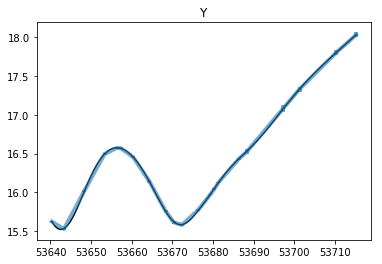

[  1.00000000e-04   1.00000000e+05]


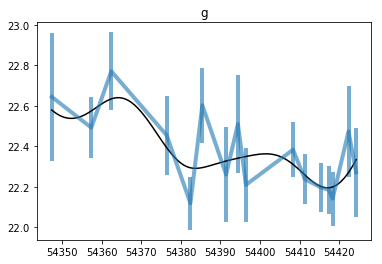

[  1.00000000e-04   1.00000000e+05]


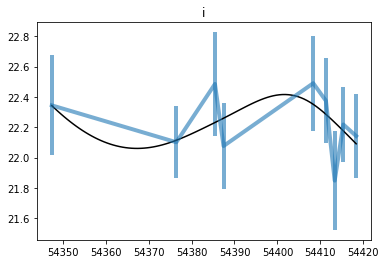

[  1.00000000e-04   1.00000000e+05]


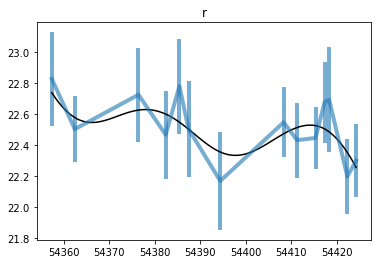

[  1.00000000e-04   1.00000000e+05]


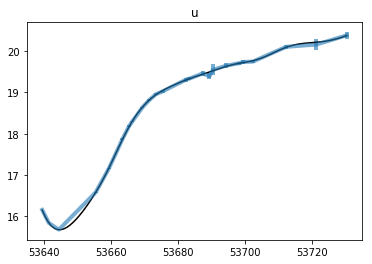

In [7]:
for filt in output_lcurves:
    #if not 'rpri' in filt:
    #    continue
    mjd = np.array(output_lcurves[filt]['t'])
    mag = np.array(output_lcurves[filt]['y'])
    magerr = np.array(output_lcurves[filt]['err'])
    modelmjd = output_lcurves[filt]['out_t']
    modelmag = output_lcurves[filt]['out_y']
    pars = output_lcurves[filt]['pars']
    print(pars)
    
    plt.errorbar(mjd,mag,yerr=magerr, alpha = 0.6, linewidth=4)
    plt.plot(modelmjd, modelmag, color='black')
    plt.title(filt)
    plt.show()

In [3]:
output_lcurves = {}

for filter_name in file_data:
    if filter_name == 'B__CSP':
        continue
    t = np.array(file_data[filter_name]['mjd'])
    y = np.array(file_data[filter_name]['mag'])
    err = np.array(file_data[filter_name]['dmag'])

    #gp = george.GP(kernel, mean=np.mean(y))
    g=dgp.DGaussianProcess(t, y, err, cXstar=(t.min(), t.max(), 128), covfunction = SquaredExponential, scaletrain='True', grad='True')
    initheta = [5] * 2
    rec, theta = g.gp(theta=initheta)
    tout = rec[:,0]
    yout = rec[:,1]
    errout = rec[:,2]
    #plt.plot(x,mu, color='r')
    #plt.errorbar(t,y,yerr=err)
    #plt.show()
    output_lcurves[filter_name] = {
        't': t,
        'y': y,
        'err': err,
        'out_t': tout,
        'out_y': yout,
        'out_err': errout,
        'pars': theta
    }

/home/levicivita/Downloads/GaPP/gapp/gp.py:497: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (self.alpha == None):
/home/levicivita/Downloads/GaPP/gapp/gp.py:514: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (self.alpha == None):



Optimized hyperparameters:
theta = [ 12.17914476  13.84095439]

Optimized hyperparameters:
theta = [   22.43752683  4735.40564622]

Optimized hyperparameters:
theta = [  2.20901085e+01   4.50202982e+04]

Optimized hyperparameters:
theta = [    22.50116486  10261.70245441]

Optimized hyperparameters:
theta = [ 16.23790275  18.02843233]


/home/levicivita/Downloads/GaPP/gapp/gp.py:568: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (self.alpha == None):


[ 0.006  0.012  0.015  0.011  0.012  0.012  0.011  0.017  0.015  0.018
  0.009  0.011  0.01   0.009  0.005  0.014  0.028  0.045  0.031  0.033
  0.033]
[ 12.17914476  13.84095439]


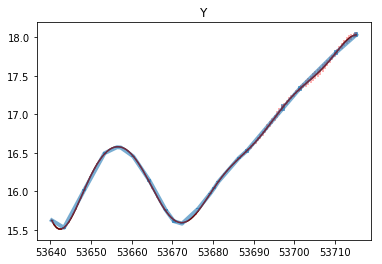

[ 0.317       0.15099999  0.193       0.19499999  0.132       0.185       0.233
  0.241       0.184       0.13500001  0.124       0.119       0.119       0.134
  0.226       0.22      ]
[   22.43752683  4735.40564622]


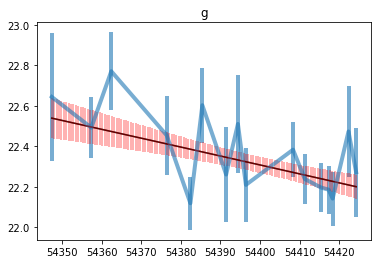

[ 0.329       0.237       0.34099999  0.28600001  0.31400001  0.28099999
  0.32499999  0.245       0.27900001]
[  2.20901085e+01   4.50202982e+04]


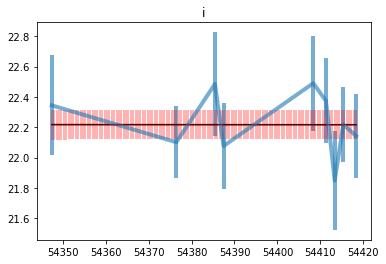

[ 0.301       0.214       0.30199999  0.285       0.30599999  0.31
  0.31600001  0.22499999  0.242       0.20299999  0.26100001  0.33899999
  0.23999999  0.237     ]
[    22.50116486  10261.70245441]


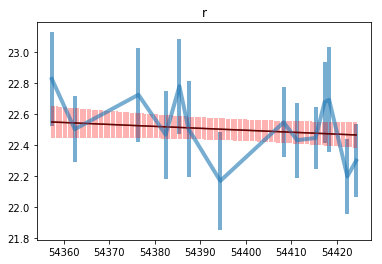

[ 0.006       0.006       0.007       0.008       0.014       0.021       0.018
  0.017       0.018       0.018       0.021       0.028       0.049       0.034
  0.05        0.078       0.13600001  0.057       0.038       0.037       0.034
  0.041       0.12800001  0.076     ]
[ 16.23790275  18.02843233]


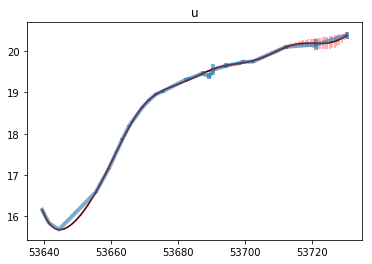

In [4]:
for filt in output_lcurves:
    #if not 'rpri' in filt:
    #    continue
    mjd = np.array(output_lcurves[filt]['t'])
    mag = np.array(output_lcurves[filt]['y'])
    magerr = np.array(output_lcurves[filt]['err'])
    print(magerr)
    modelmjd = output_lcurves[filt]['out_t']
    modelmag = output_lcurves[filt]['out_y']
    modelerr = output_lcurves[filt]['out_err']
    pars = output_lcurves[filt]['pars']
    print(pars)
    
    plt.errorbar(mjd,mag,yerr=magerr, alpha = 0.6, linewidth=4)
    plt.plot(modelmjd, modelmag, color='black')
    plt.errorbar(modelmjd, modelmag, yerr=modelerr, color='red', alpha=0.4)
    plt.title(filt)
    plt.show()

In [15]:
output_lcurves = {}

for filter_name in file_data:
    if filter_name == 'B__CSP':
        continue
    t = np.array(file_data[filter_name]['mjd'])
    y = np.array(file_data[filter_name]['mag'])
    err = np.array(file_data[filter_name]['dmag'])

    #gp = george.GP(kernel, mean=np.mean(y))
    t = np.arange(20)
    err = np.random.normal(0, 0.1, len(t))
    y = np.sin(t/np.pi) + err
    print(t, y)
    
    nwalker=100
    initheta = np.random.normal(10.0, 5, (nwalker, 2))
    print(initheta)
    g=mcmcgp.MCMCGaussianProcess(t, y, err, initheta, Niter=2000, cXstar=(t.min(), t.max(), 50), sampling='True')
    xstar, fvals = g.mcmcgp()
    print(rec, theta, test)
    tout = rec[:,0]
    yout = rec[:,1]
    errout = rec[:,2]
    #plt.plot(x,mu, color='r')
    #plt.errorbar(t,y,yerr=err)
    #plt.show()
    output_lcurves[filter_name] = {
        't': t,
        'y': y,
        'err': err,
        'out_t': tout,
        'out_y': yout,
        'out_err': errout,
        'pars': theta
    }

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [-0.06079283  0.21015861  0.57917066  0.60965778  0.92184772  0.77422208
  0.82671683  0.74902015  0.5340064   0.29193525  0.14861336 -0.24594227
 -0.52696456 -0.8157205  -0.97181993 -0.96403959 -0.9063614  -0.81365539
 -0.46493775 -0.0895423 ]
[[  5.71362356   8.26437029]
 [  2.0482481    6.84906945]
 [  3.7769417    7.70043589]
 [  9.72348324   6.20768337]
 [  7.56516609  13.52606515]
 [  7.01308887  10.69963537]
 [  6.77344699  11.95971604]
 [ 12.97113523   6.00382195]
 [  7.194837    13.89903835]
 [ 10.9781925   17.95617078]
 [  8.75924765  13.27663751]
 [ 14.47852982   4.61068646]
 [  3.39456812   3.43067629]
 [  6.83698147   8.92308527]
 [ 13.08837999  13.81790844]
 [  8.04399808   4.83698206]
 [ 18.04579752   8.76849498]
 [ -6.83388198   2.76481256]
 [ 12.18255957  12.16375121]
 [  8.8881867    3.81734047]
 [ 12.56304572   8.23654791]
 [  8.99164658  14.54089798]
 [  9.77750836  11.287214  ]
 [  5.03704852   4.5157958

/home/levicivita/Downloads/GaPP/gapp/gp.py:81: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (theta == None):
/home/levicivita/Downloads/GaPP/gapp/covfunctions/squex.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (theta == None):
/home/levicivita/Downloads/GaPP/gapp/gp.py:352: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (xmin == None or xmax == None):
/home/levicivita/Downloads/GaPP/gapp/gp.py:497: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (self.alpha == None):
/home/levicivita/.local/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/levicivita/.local/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid

AutocorrError: The chain is too short

In [ ]:
for filt in output_lcurves:
    #if not 'rpri' in filt:
    #    continue
    mjd = np.array(output_lcurves[filt]['t'])
    mag = np.array(output_lcurves[filt]['y'])
    magerr = np.array(output_lcurves[filt]['err'])
    print(magerr)
    modelmjd = output_lcurves[filt]['out_t']
    modelmag = output_lcurves[filt]['out_y']
    modelerr = output_lcurves[filt]['out_err']
    pars = output_lcurves[filt]['pars']
    print(pars)
    
    plt.errorbar(mjd,mag,yerr=magerr, alpha = 0.6, linewidth=4)
    plt.plot(modelmjd, modelmag, color='black')
    plt.errorbar(modelmjd, modelmag, yerr=modelerr, color='red', alpha=0.4)
    plt.title(filt)
    plt.show()